# Movie recommender engine in Spark/Elastic Search


<a href="http://tinypic.com?ref=op4mww" target="_blank"><img src="http://i64.tinypic.com/op4mww.png" border="0" alt="Image and video hosting by TinyPic"></a>
***
work is inspired by https://developer.ibm.com/patterns/build-a-recommender-with-apache-spark-and-elasticsearch/
*** 
work flow is listed as below:
1. Load the movie dataset into Spark.

2. Use Spark DataFrame operations to clean up the dataset and load it into Elasticsearch.

3. Using Spark MLlib, train a collaborative filtering recommendation model.

4. Save the resulting model into Elasticsearch.

5. Using Elasticsearch queries and a custom vector scoring plugin, generate some example recommendations. The Movie Database API is used to display movie poster images for the recommended movie.

required module for the project

In [3]:
import re
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import pyspark
from IPython.display import Image, HTML, display
from elasticsearch import Elasticsearch
import elasticsearch
import sys
from pyspark import SparkContext, SparkConf
from pyspark.sql.types import *
from pyspark.sql.functions import col, mean, udf, lit, current_timestamp, unix_timestamp, array_contains
from pyspark.ml.recommendation import ALS
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.recommendation import ALS
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.ml.evaluation import RegressionEvaluator
import tmdbsimple as tmdb
import matplotlib.pyplot as plt

key to run file in local dir, direct to the dir where spark is installed, create a .sh file with following line:

<font color = yellow> export PYSPARK_DRIVER_PYTHON=jupyter</font> 
    
<font color = yellow> export PYSPARK_DRIVER_PYTHON_OPTS='lab'</font>
    
<font color = yellow> SPARK_LOCAL_IP=127.0.0.1 ./bin/pyspark </font>

run .sh file to start the interface in Jupyter lab

#### Before we begin:
#### <font color = orange>Now make sure that spark can be runned</font>

PYSPARK_DRIVER_PYTHON="jupyter" PYSPARK_DRIVER_PYTHON_OPTS="notebook" ../spark-2.2.0-bin-hadoop2.7/bin/pyspark --driver-memory 4g --driver-class-path ../../elasticsearch-hadoop-5.3.0/dist/elasticsearch-spark-20_2.11-5.3.0.jar

In [4]:
spark

#### <font color = orange>Now make sure that elastic search is successfully installed and can be runned</font>
1. "brew services start elasticsearch" to start the engine
2. "brew services stop elasticsearch" to stop the engine

In [5]:
#start the engine first
!brew services start elasticsearch
# test your ES instance is running
es = Elasticsearch()
es.info(pretty=True)

==> Successfully started `elasticsearch` (label: homebrew.mxcl.elasticsearch)


{'name': 'TyKl1Ia',
 'cluster_name': 'elasticsearch',
 'cluster_uuid': 'U75evdOSS3mxA5KeOozyRA',
 'version': {'number': '5.3.0',
  'build_hash': '3adb13b',
  'build_date': '2017-03-23T03:31:50.652Z',
  'build_snapshot': False,
  'lucene_version': '6.4.1'},
 'tagline': 'You Know, for Search'}

In [6]:
#now stop the engine
!brew services stop elasticsearch

Stopping `elasticsearch`... (might take a while)
==> Successfully stopped `elasticsearch` (label: homebrew.mxcl.elasticsearch)


#### <font color = orange>Lastly, install the tmdbsimple module for data visualization</font>

tmdb is important as we desire to output the poster/picture of the movie with a key of movieId in the database

simply: *"pip install tmdbsimple"*

further reference: https://pypi.org/project/tmdbsimple/
<a href="http://tinypic.com?ref=23j0hfq" target="_blank"><img src="http://i65.tinypic.com/23j0hfq.png" border="0" alt="Image and video hosting by TinyPic"></a>

#### Now let's begin the project

In [7]:
##import csv files
ratings = spark.read.csv("ratings.csv", header=True)
ratings.cache()
links = spark.read.csv("./links.csv", header=True)
links.cache()
movies = spark.read.csv("./movies.csv", header = True)
movies.cache()

DataFrame[movieId: string, title: string, genres: string]

In [8]:
#preview of the data structures
ratings.schema

StructType(List(StructField(userId,StringType,true),StructField(movieId,StringType,true),StructField(rating,StringType,true),StructField(timestamp,StringType,true)))

In [9]:
ratings.show(7)

+------+-------+------+---------+
|userId|movieId|rating|timestamp|
+------+-------+------+---------+
|     1|      1|   4.0|964982703|
|     1|      3|   4.0|964981247|
|     1|      6|   4.0|964982224|
|     1|     47|   5.0|964983815|
|     1|     50|   5.0|964982931|
|     1|     70|   3.0|964982400|
|     1|    101|   5.0|964980868|
+------+-------+------+---------+
only showing top 7 rows



In [10]:
#preview of the data structures
movies.schema

StructType(List(StructField(movieId,StringType,true),StructField(title,StringType,true),StructField(genres,StringType,true)))

In [11]:
movies.show(7,truncate=False)

+-------+----------------------------------+-------------------------------------------+
|movieId|title                             |genres                                     |
+-------+----------------------------------+-------------------------------------------+
|1      |Toy Story (1995)                  |Adventure|Animation|Children|Comedy|Fantasy|
|2      |Jumanji (1995)                    |Adventure|Children|Fantasy                 |
|3      |Grumpier Old Men (1995)           |Comedy|Romance                             |
|4      |Waiting to Exhale (1995)          |Comedy|Drama|Romance                       |
|5      |Father of the Bride Part II (1995)|Comedy                                     |
|6      |Heat (1995)                       |Action|Crime|Thriller                      |
|7      |Sabrina (1995)                    |Comedy|Romance                             |
+-------+----------------------------------+-------------------------------------------+
only showing top 7 ro

In [12]:
#preview of the data structures
links.schema

StructType(List(StructField(movieId,StringType,true),StructField(imdbId,StringType,true),StructField(tmdbId,StringType,true)))

In [13]:
links.show(7,truncate=False)

+-------+-------+------+
|movieId|imdbId |tmdbId|
+-------+-------+------+
|1      |0114709|862   |
|2      |0113497|8844  |
|3      |0113228|15602 |
|4      |0114885|31357 |
|5      |0113041|11862 |
|6      |0113277|949   |
|7      |0114319|11860 |
+-------+-------+------+
only showing top 7 rows



number of unique users in the ratings csv

In [14]:
ratings.select('userID').distinct().count()

610

number of unique movies that have been rated

In [15]:
ratings.select("movieId").distinct().count()

9724

In [16]:
movies.select("movieId").distinct().count()

9742

#### --create a temporary view, and show movies(Movie-ID, Movie title) are not rated before in a temporary view using sql

In [17]:
ratings.createOrReplaceTempView("ratings_view")
movies.createOrReplaceTempView("movies_view")
# List movies not rated before
not_rated = spark.sql(
    '''SELECT DISTINCT movieID,title
       FROM movies_view 
       WHERE movieID NOT IN (SELECT DISTINCT movieID FROM ratings_view)
    ''')

In [18]:
not_rated.toPandas()

,movieID,title
0,3338,For All Mankind (1989)
1,34482,"Browning Version, The (1951)"
2,2939,Niagara (1953)
3,3456,"Color of Paradise, The (Rang-e khoda) (1999)"
4,30892,In the Realms of the Unreal (2004)
5,7792,"Parallax View, The (1974)"
6,32160,Twentieth Century (1934)
7,26085,Mutiny on the Bounty (1962)
8,1076,"Innocents, The (1961)"
9,4194,I Know Where I'm Going! (1945)


movie dataset

explore genres of movie

In [19]:
print("There are %d unique genres in the rating system "%\
      len(set(movies.select('genres').rdd.flatMap(list).flatMap(lambda x:x.split("|")).collect())))

There are 20 unique genres in the rating system 


below are the uniqre genres in the rating system

In [20]:
#and here we list the movie genres below
genre_set = set(movies.select('genres').rdd.flatMap(list).flatMap(lambda x:x.split("|")).collect())
genre_set

{'(no genres listed)',
 'Action',
 'Adventure',
 'Animation',
 'Children',
 'Comedy',
 'Crime',
 'Documentary',
 'Drama',
 'Fantasy',
 'Film-Noir',
 'Horror',
 'IMAX',
 'Musical',
 'Mystery',
 'Romance',
 'Sci-Fi',
 'Thriller',
 'War',
 'Western'}

### 1.1 Exploratory Data Analysis

For the ease of EDA, convert the dataframe into a pandas data frame

In [21]:
ratings.groupBy('rating').count().toPandas()

,rating,count
0,1.0,2811
1,4.5,8551
2,2.5,5550
3,3.5,13136
4,5.0,13211
5,0.5,1370
6,4.0,26818
7,1.5,1791
8,2.0,7551
9,3.0,20047


Text(0.5, 1.0, 'rating counts')

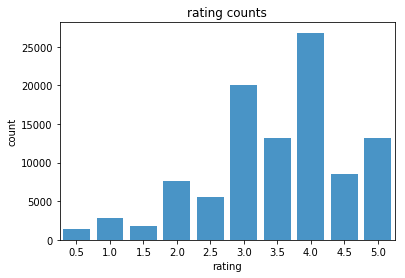

In [22]:
# count of different rating scores
sns.barplot(x="rating", y="count", color='#3498db', data=ratings.groupBy('rating').count().toPandas()).set_title('rating counts')

Average ratings of each movie

In [23]:
# average rating of movies
ratings.groupBy('MovieID').agg(mean('rating')).toPandas().head(7)

,MovieID,avg(rating)
0,296,4.197068
1,1090,3.984127
2,115713,3.910714
3,3210,3.476190
4,88140,3.546875
5,829,2.666667
6,2088,2.500000


average rating from users

In [24]:
# average rating from users
ratings.groupBy('userID').agg(mean('rating')).toPandas().head(7)

,userID,avg(rating)
0,296,4.166667
1,467,3.409091
2,125,3.859722
3,451,3.794118
4,7,3.230263
5,51,3.775766
6,124,3.990000


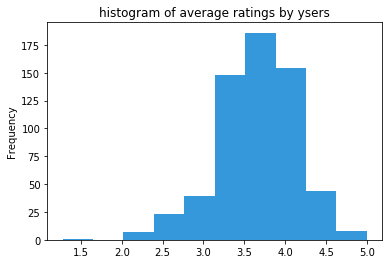

In [25]:
# average rating from users
ratings.groupBy('userID').agg(mean('rating')).toPandas()['avg(rating)'].plot(kind='hist', 
                                                                             color='#3498db',title = "histogram of average ratings by ysers")


### 1.2 Raw Data Prepossessing using Spark sql
first thing comes in mind is the data formation of the *genres*, which is "|" delimited and hard to handle, so we define a UDF(user-defined function to transform the *genres* to a list of strings )

udf-user define function reference can be found in here:https://changhsinlee.com/pyspark-udf/


In [26]:
# define a UDF to convert the raw genres string to an array of genres and lowercase
split_genres = udf(lambda s: s.lower().split("|"), ArrayType(StringType()))
# test the UDF for the first 5 movies in the dataset
movies.select("movieId", "title", split_genres("genres").alias("genres")).show(5, False)

+-------+----------------------------------+-------------------------------------------------+
|movieId|title                             |genres                                           |
+-------+----------------------------------+-------------------------------------------------+
|1      |Toy Story (1995)                  |[adventure, animation, children, comedy, fantasy]|
|2      |Jumanji (1995)                    |[adventure, children, fantasy]                   |
|3      |Grumpier Old Men (1995)           |[comedy, romance]                                |
|4      |Waiting to Exhale (1995)          |[comedy, drama, romance]                         |
|5      |Father of the Bride Part II (1995)|[comedy]                                         |
+-------+----------------------------------+-------------------------------------------------+
only showing top 5 rows



UDF to extra the year using regex (from the title column to make it usable for a search index later)

In [27]:
import re
def udf_get_year(title):
    '''
    user defined function to split the year and title from the title column of the
    raw datas from movies
    '''
    if not isinstance(title, str):
        raise TypeError("invalid type of input")
    title_year_res = re.search(r"\d{4}",title)
    #print(title_year_res)
    try:
        if title_year_res:
            year = title_year_res.group()
            #strip spaces for the tile
            #print(title_year_res.start())
            title = title[:title_year_res.start()-1].strip()
            return (title,year)
        #if not found, assign it to 1970
        else:
            return (title.strip(), 1970)
    except:
        print("error")
#make sure the UDF return a string type for two 
split_title = udf(udf_get_year,
                   StructType([StructField("title", StringType(), True),
                   StructField("release_year", StringType(), True)]))
    

Now we use to UDF to get the desired cleaned dataframe

In [28]:
#make alias and show the cleaned head of the df
movies = movies.select('movieId',
              split_title('title').title.alias('title'),
              split_title('title').release_year.alias('release_year'),
              split_genres("genres").alias("genres"))

In [29]:
movies.show(7, truncate=False)

+-------+---------------------------+------------+-------------------------------------------------+
|movieId|title                      |release_year|genres                                           |
+-------+---------------------------+------------+-------------------------------------------------+
|1      |Toy Story                  |1995        |[adventure, animation, children, comedy, fantasy]|
|2      |Jumanji                    |1995        |[adventure, children, fantasy]                   |
|3      |Grumpier Old Men           |1995        |[comedy, romance]                                |
|4      |Waiting to Exhale          |1995        |[comedy, drama, romance]                         |
|5      |Father of the Bride Part II|1995        |[comedy]                                         |
|6      |Heat                       |1995        |[action, crime, thriller]                        |
|7      |Sabrina                    |1995        |[comedy, romance]                        

As we wish to connect the dataset to the Movie/IMDB database to display corresponding poster as in the future, we ought to join the links.csv data to movies so that there is an id(INDEX) for The Movie Database corresponding to each movie. 

In [30]:
links.show(3,truncate=False)

+-------+-------+------+
|movieId|imdbId |tmdbId|
+-------+-------+------+
|1      |0114709|862   |
|2      |0113497|8844  |
|3      |0113228|15602 |
+-------+-------+------+
only showing top 3 rows



In [31]:
#now we join both data frame on movieId to get the new data frame
movie_cleaned = movies.join(links, movies.movieId == links.movieId)\
    .select(movies.movieId, movies.title, movies.release_year, movies.genres, links.tmdbId, links.imdbId)

Below is out final dataframe after the manipulations and preposessing

In [32]:
movie_cleaned.show(5, truncate=False)

+-------+---------------------------+------------+-------------------------------------------------+------+-------+
|movieId|title                      |release_year|genres                                           |tmdbId|imdbId |
+-------+---------------------------+------------+-------------------------------------------------+------+-------+
|1      |Toy Story                  |1995        |[adventure, animation, children, comedy, fantasy]|862   |0114709|
|2      |Jumanji                    |1995        |[adventure, children, fantasy]                   |8844  |0113497|
|3      |Grumpier Old Men           |1995        |[comedy, romance]                                |15602 |0113228|
|4      |Waiting to Exhale          |1995        |[comedy, drama, romance]                         |31357 |0114885|
|5      |Father of the Bride Part II|1995        |[comedy]                                         |11862 |0113041|
+-------+---------------------------+------------+----------------------

In [33]:
movie_cleaned.first().tmdbId

'862'

#### 1.3 Get the API key from movie database and display poster and more info

Successfully imported tmdbsimple!


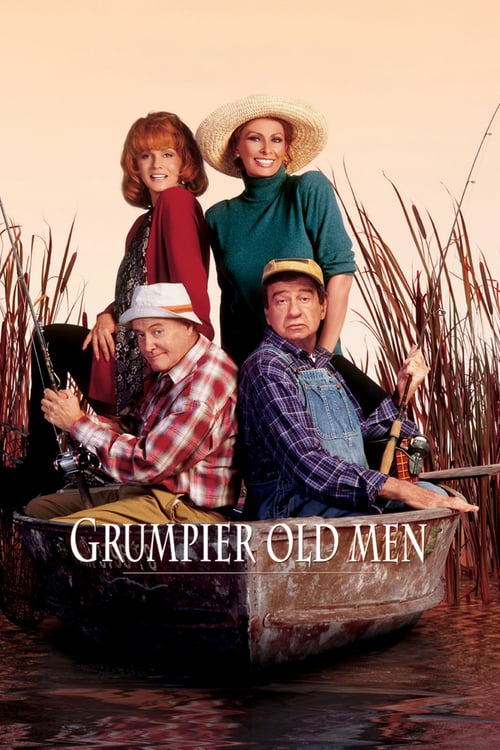

In [34]:
import tmdbsimple as tmdb
tmdb.API_KEY = '5a578b4d39629dffa671710aa742b57c'
print("Successfully imported tmdbsimple!")
# base URL for TMDB poster images
IMAGE_URL = 'https://image.tmdb.org/t/p/w500'
#movie_id = movie_cleaned.first().tmdbId
movie_info = tmdb.Movies(15602).info()
movie_poster_url = IMAGE_URL + movie_info['poster_path']
display(Image(movie_poster_url, width=250))

### 2.1 Loaded the cleaned data frames into elastic search

we have the cluster information for the search engine

In [35]:
es = Elasticsearch()
es.info(pretty=True)

{'name': 'TyKl1Ia',
 'cluster_name': 'elasticsearch',
 'cluster_uuid': 'U75evdOSS3mxA5KeOozyRA',
 'version': {'number': '5.3.0',
  'build_hash': '3adb13b',
  'build_date': '2017-03-23T03:31:50.652Z',
  'build_snapshot': False,
  'lucene_version': '6.4.1'},
 'tagline': 'You Know, for Search'}

**before we get going, since elastic search is using milisecond time based timestamp, lets transform our timestamp into that version**

In [36]:
ratings = ratings.select(
    ratings.userId, ratings.movieId, ratings.rating, (ratings.timestamp.cast("long") * 1000).alias("timestamp"))

ratings.show(5)

+------+-------+------+------------+
|userId|movieId|rating|   timestamp|
+------+-------+------+------------+
|     1|      1|   4.0|964982703000|
|     1|      3|   4.0|964981247000|
|     1|      6|   4.0|964982224000|
|     1|     47|   5.0|964983815000|
|     1|     50|   5.0|964982931000|
+------+-------+------+------------+
only showing top 5 rows



Delete if already existed

In [37]:
es.indices.delete(index="movie_rec")

{'acknowledged': True}

In [38]:
create_index = {
    "settings": {
        "analysis": {
            "analyzer": {
                # this configures the custom analyzer we need to parse vectors such that the scoring
                # plugin will work correctly
                "payload_analyzer": {
                    "type": "custom",
                    "tokenizer":"whitespace",
                    "filter":"delimited_payload_filter"
                }
            }
        }
    },
    "mappings": {
        "ratings": {
          # this mapping definition sets up the fields for the rating events
          "properties": {
                "timestamp": {
                    "type": "date"
                },
                "userId": {
                    "type": "integer"
                },
                "movieId": {
                    "type": "integer"
                },
                "rating": {
                    "type": "double"
                }
            }  
        },
        "users": {
            # this mapping definition sets up the metadata fields for the users
            "properties": {
                "userId": {
                    "type": "integer"
                },
                "@model": {
                    # this mapping definition sets up the fields for user factor vectors of our model
                    "properties": {
                        "factor": {
                            "type": "text",
                            "term_vector": "with_positions_offsets_payloads",
                            "analyzer" : "payload_analyzer"
                        },
                        "version": {
                            "type": "keyword"
                        },
                        "timestamp": {
                            "type": "date"
                        }
                    }
                }
            }
        },
        "movies": {
            # this mapping definition sets up the metadata fields for the movies
            "properties": {
                "movieId": {
                    "type": "integer"
                },
                "tmdbId": {
                    "type": "keyword"
                },
                "genres": {
                    "type": "keyword"
                },
                "release_date": {
                    "type": "date",
                    "format": "year"
                },
                "@model": {
                    # this mapping definition sets up the fields for movie factor vectors of our model
                    "properties": {
                        "factor": {
                            "type": "text",
                            "term_vector": "with_positions_offsets_payloads",
                            "analyzer" : "payload_analyzer"
                        },
                        "version": {
                            "type": "keyword"
                        },
                        "timestamp": {
                            "type": "date"
                        }
                    }
                }
            }
        }
    }
}

# create index with the settings and mappings above
es.indices.create(index="movie_rec", body=create_index)

{'acknowledged': True, 'shards_acknowledged': True}

In [39]:
# write ratings data
ratings.write.format("es").save("movie_rec/ratings")

# write movie data, specifying the DataFrame column to use as the id mapping
# each document has an unique id 
# if it is not specified, an id will be assigned by Elasticsearch
movie_cleaned.write.format("es").option("es.mapping.id", "movieId").save("movie_rec/movies")

# check load went ok
print("Movie DF count: %d" % movie_cleaned.count())
print("ES index count: %d" % es.count(index="movie_rec", doc_type="movies")['count'])

# check write went ok
print("Rating DF count: %d" % ratings.count())
print("ES index count:  %d" % es.count(index="movie_rec", doc_type="ratings")['count'])

Movie DF count: 9742
ES index count: 9742
Rating DF count: 100836
ES index count:  100836


In [40]:
# test things out by retrieving 3 rating documents from Elasticsearch
es.search(index="movie_rec", q="*", size=3)

{'took': 5,
 'timed_out': False,
 '_shards': {'total': 5, 'successful': 5, 'failed': 0},
 'hits': {'total': 110578,
  'max_score': 1.0,
  'hits': [{'_index': 'movie_rec',
    '_type': 'ratings',
    '_id': 'AWtlaUZEi3uZMVt8gb0s',
    '_score': 1.0,
    '_source': {'userId': '1',
     'movieId': '216',
     'rating': '5.0',
     'timestamp': 964981208000}},
   {'_index': 'movie_rec',
    '_type': 'ratings',
    '_id': 'AWtlaUZEi3uZMVt8gb0z',
    '_score': 1.0,
    '_source': {'userId': '1',
     'movieId': '333',
     'rating': '5.0',
     'timestamp': 964981179000}},
   {'_index': 'movie_rec',
    '_type': 'ratings',
    '_id': 'AWtlaUZEi3uZMVt8gb01',
    '_score': 1.0,
    '_source': {'userId': '1',
     'movieId': '356',
     'rating': '4.0',
     'timestamp': 964980962000}}]}}

In [41]:
# we can use es to query documents 
# e.g. count ratings with timestamp between 2016-01-01 and 2016-02-01
es.count(index="movie_rec", doc_type="ratings", q="timestamp:[2016-01-01 TO 2016-02-01]")

{'count': 344, '_shards': {'total': 5, 'successful': 5, 'failed': 0}}

In [42]:
# test things out by searching for movies containing "matrix" in the title
es.search(index="movie_rec", q="title:matrix", size=3)

{'took': 1,
 'timed_out': False,
 '_shards': {'total': 5, 'successful': 5, 'failed': 0},
 'hits': {'total': 3,
  'max_score': 6.9545727,
  'hits': [{'_index': 'movie_rec',
    '_type': 'movies',
    '_id': '2571',
    '_score': 6.9545727,
    '_source': {'movieId': '2571',
     'title': 'Matrix, The',
     'release_year': '1999',
     'genres': ['action', 'sci-fi', 'thriller'],
     'tmdbId': '603',
     'imdbId': '0133093'}},
   {'_index': 'movie_rec',
    '_type': 'movies',
    '_id': '6365',
    '_score': 5.8152814,
    '_source': {'movieId': '6365',
     'title': 'Matrix Reloaded, The',
     'release_year': '2003',
     'genres': ['action', 'adventure', 'sci-fi', 'thriller', 'imax'],
     'tmdbId': '604',
     'imdbId': '0234215'}},
   {'_index': 'movie_rec',
    '_type': 'movies',
    '_id': '6934',
    '_score': 5.8152814,
    '_source': {'movieId': '6934',
     'title': 'Matrix Revolutions, The',
     'release_year': '2003',
     'genres': ['action', 'adventure', 'sci-fi', 'thri

### 3.1 Train a recommmender system

In [46]:
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.recommendation import ALS
from pyspark.sql import Row
#read from the elastic search
ratings_from_es = spark.read.format("es").load("movie_rec/ratings")
# train test split
train, test = ratings_from_es.randomSplit([0.7, 0.3])
train.show(5)

+-------+------+-------------------+------+
|movieId|rating|          timestamp|userId|
+-------+------+-------------------+------+
|      1|   2.0|2015-11-14 11:24:17|   298|
|      1|   2.5|2011-09-18 20:17:37|   432|
|      1|   2.5|2012-10-01 05:15:50|   606|
|      1|   3.0|1997-01-22 07:57:35|   214|
|      1|   3.0|1998-07-23 17:00:02|   283|
+-------+------+-------------------+------+
only showing top 5 rows



<font color = orange>reference for ALS and training process</font>

https://spark.apache.org/docs/2.2.0/api/java/index.html?org/apache/spark/ml/tuning/ParamGridBuilder.html

https://spark.apache.org/docs/2.2.0/ml-collaborative-filtering.html

In [47]:
als_obj = ALS()

# use grid search to tune parameters
params_grid  = ParamGridBuilder()\
    .baseOn({als_obj.coldStartStrategy: "drop"})\
    .baseOn({als_obj.userCol: "userId"})\
    .baseOn({als_obj.itemCol: "movieId"})\
    .baseOn({als_obj.ratingCol: "rating"})\
    .baseOn({als_obj.maxIter: 20})\
    .addGrid(als_obj.regParam, [1e-3, 0.05, 0.1, 0.5, 1, 10])\
    .addGrid(als_obj.rank, [10, 12, 14, 20, 50])\
    .build()

# define evaluator with mse eror
mse_evaluator = RegressionEvaluator(metricName="rmse", labelCol="rating", predictionCol="prediction")

# 3-fold cross validation
cv_setting = CrossValidator(estimator=als_obj, estimatorParamMaps=params_grid, evaluator=mse_evaluator, numFolds=2)
cv_model = cv_setting.fit(train)

In [48]:
model = cv_model.bestModel
model.userFactors.show(5)
model.itemFactors.show(5)

+---+--------------------+
| id|            features|
+---+--------------------+
| 10|[-0.036844075, -0...|
| 20|[-0.25389126, -0....|
| 30|[-0.30601192, -0....|
| 40|[-0.40995902, 0.0...|
| 50|[-0.49741107, -0....|
+---+--------------------+
only showing top 5 rows

+---+--------------------+
| id|            features|
+---+--------------------+
| 10|[-0.12226631, -0....|
| 20|[-0.21993649, 0.0...|
| 30|[-0.38873646, -0....|
| 40|[0.010840754, -0....|
| 50|[-0.6830349, -0.2...|
+---+--------------------+
only showing top 5 rows



In [49]:
print("parameters of the best model: \n{}".format(cv_setting.getEstimatorParamMaps()[np.argmin(cv_model.avgMetrics)]))
print("\n")
print("cross validation RMSE of the best model: {}".format(min(cv_model.avgMetrics)))

parameters of the best model: 
{Param(parent='ALS_3a719eccdde9', name='coldStartStrategy', doc="strategy for dealing with unknown or new users/items at prediction time. This may be useful in cross-validation or production scenarios, for handling user/item ids the model has not seen in the training data. Supported values: 'nan', 'drop'."): 'drop', Param(parent='ALS_3a719eccdde9', name='userCol', doc='column name for user ids. Ids must be within the integer value range.'): 'userId', Param(parent='ALS_3a719eccdde9', name='itemCol', doc='column name for item ids. Ids must be within the integer value range.'): 'movieId', Param(parent='ALS_3a719eccdde9', name='ratingCol', doc='column name for ratings'): 'rating', Param(parent='ALS_3a719eccdde9', name='maxIter', doc='max number of iterations (>= 0).'): 20, Param(parent='ALS_3a719eccdde9', name='regParam', doc='regularization parameter (>= 0).'): 0.1, Param(parent='ALS_3a719eccdde9', name='rank', doc='rank of the factorization'): 50}


cross v

#### 3.2 Evaluate the metrics

**Comparision of the metric**

In [53]:
a = iter(list(cv_model.avgMetrics[:]))
res = []
for Lambda in [1e-3, 0.05, 0.1, 0.5, 1, 10]:
    for K in [10, 12, 14, 20, 50]:
        res.append((Lambda, K, next(a)))
for item in res:
    print('|' + '|'.join(list(map(str, item))) + '|')

|0.001|10|1.6455148114215379|
|0.001|12|1.6511729751246456|
|0.001|14|1.7022241473384871|
|0.001|20|1.8712182915439501|
|0.001|50|2.183054482567835|
|0.05|10|0.9886733920699331|
|0.05|12|0.9904916320948476|
|0.05|14|0.979228760248473|
|0.05|20|0.9615416895505025|
|0.05|50|0.9308782919430134|
|0.1|10|0.9035673374284605|
|0.1|12|0.9014330306741534|
|0.1|14|0.8960966577550468|
|0.1|20|0.8898410423496492|
|0.1|50|0.8801781048319193|
|0.5|10|1.0004472735315306|
|0.5|12|1.0004633664069535|
|0.5|14|1.0004835978194306|
|0.5|20|1.0005266223416867|
|0.5|50|1.0004740948053976|
|1|10|1.3167574206419972|
|1|12|1.3167567782299927|
|1|14|1.3167556714612876|
|1|20|1.3167559487754477|
|1|50|1.3167555225226346|
|10|10|3.670924576655012|
|10|12|3.670924576655012|
|10|14|3.670924576655012|
|10|20|3.670924576655012|
|10|50|3.670924576655012|


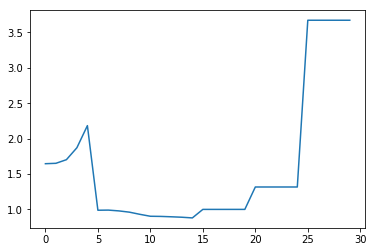

In [54]:
plt.plot([i[2] for i in res])

Test against the testing_set

In [55]:
mse_evaluator.evaluate((model.transform(test)))

0.6645615457667956

### 4.1: Export ALS user and item factor vectors to Elasticsearch
The next step is to export the model factors (shown in the DataFrames above) to Elasticsearch.

In order to store the model in the correct format for the index mappings set up earlier, you will need to create some utility functions. These functions will allow you to convert the raw vectors (which are equivalent to a Python list in the factor DataFrames above) to the correct delimited string format. This ensures Elasticsearch will parse the vector field in the model correctly using the delimited token filter custom analyzer you configured earlier.

You will also create a function to convert a vector and related metadata (such as the Spark model id and a timestamp) into a DataFrame field that matches the model field in the Elasticsearch index mapping.

In [57]:
def convert_vector(x):
    '''Convert a list or numpy array to delimited token filter format'''
    return " ".join(["%s|%s" % (i, v) for i, v in enumerate(x)])

def reverse_convert(s):
    '''Convert a delimited token filter format string back to list format'''
    return  [float(f.split("|")[1]) for f in s.split(" ")]

def vector_to_struct(x, version, ts):
    '''Convert a vector to a SparkSQL Struct with string-format vector and version fields'''
    return (convert_vector(x), version, ts)
#convert the data type into a udf
vector_struct = udf(vector_to_struct, \
                    StructType([StructField("factor", StringType(), True), \
                                StructField("version", StringType(), True),\
                                StructField("timestamp", LongType(), True)]))

In [60]:
convert_vector([1,2,3])

'0|1 1|2 2|3'

In [62]:
# test out the vector conversion function
test_vec = model.userFactors.select("features").first().features
print(test_vec)
print()
print()
print(convert_vector(test_vec))

[-0.036844074726104736, -0.30367812514305115, -0.20650945603847504, -0.2706626057624817, -0.26892849802970886, -0.03617718443274498, -0.07164626568555832, -0.003707219148054719, 0.1647254377603531, -0.4403136670589447, -0.6732355356216431, -0.002471276093274355, -0.3251093327999115, -0.023179251700639725, 0.5499812960624695, 0.03281314671039581, -0.26509737968444824, 0.2246880680322647, -0.27820223569869995, -0.08648097515106201, -0.5954302549362183, 0.031919751316308975, -0.19494418799877167, -0.8925859928131104, -0.07440538704395294, 0.5383099913597107, 0.06713984161615372, -0.21646897494792938, -0.5088559985160828, -0.2617456316947937, 0.1154250055551529, 0.14968135952949524, -0.19445332884788513, 0.4908030033111572, -0.04567788541316986, 0.007109437603503466, 0.5570786595344543, 0.17650002241134644, -0.3235630393028259, 0.05058997869491577, -0.7661335468292236, -0.029669681563973427, 0.2920028865337372, -0.4761051833629608, 0.18906593322753906, -0.1896744817495346, 0.12323817610740

**Convert factor vectors to [factor, version, timestamp] form and write to Elasticsearch**

In [63]:
ver = model.uid
ts = unix_timestamp(current_timestamp())

movie_vectors = model.itemFactors.select("id", vector_struct("features", lit(ver), ts).alias("@model"))
movie_vectors.select("id", "@model.factor", "@model.version", "@model.timestamp").show(5)

user_vectors = model.userFactors.select("id", vector_struct("features", lit(ver), ts).alias("@model"))
user_vectors.select("id", "@model.factor", "@model.version", "@model.timestamp").show(5)

+---+--------------------+----------------+----------+
| id|              factor|         version| timestamp|
+---+--------------------+----------------+----------+
| 10|0|-0.122266307473...|ALS_3a719eccdde9|1560776084|
| 20|0|-0.219936490058...|ALS_3a719eccdde9|1560776084|
| 30|0|-0.388736456632...|ALS_3a719eccdde9|1560776084|
| 40|0|0.0108407540246...|ALS_3a719eccdde9|1560776084|
| 50|0|-0.683034896850...|ALS_3a719eccdde9|1560776084|
+---+--------------------+----------------+----------+
only showing top 5 rows

+---+--------------------+----------------+----------+
| id|              factor|         version| timestamp|
+---+--------------------+----------------+----------+
| 10|0|-0.036844074726...|ALS_3a719eccdde9|1560776084|
| 20|0|-0.253891259431...|ALS_3a719eccdde9|1560776084|
| 30|0|-0.306011915206...|ALS_3a719eccdde9|1560776084|
| 40|0|-0.409959018230...|ALS_3a719eccdde9|1560776084|
| 50|0|-0.497411072254...|ALS_3a719eccdde9|1560776084|
+---+--------------------+--------------

In [64]:
# write data to ES, use:
# - "id" as the column to map to ES movie id
# - "update" write mode for ES, since you want to update new fields only
# - "append" write mode for Spark
movie_vectors.write.format("es") \
    .option("es.mapping.id", "id") \
    .option("es.write.operation", "update") \
    .save("movie_rec/movies", mode="append")
# write data to ES, use:
# - "id" as the column to map to ES movie id
# - "index" write mode for ES, since you have not written to the user index previously
# - "append" write mode for Spark
user_vectors.write.format("es") \
    .option("es.mapping.id", "id") \
    .option("es.write.operation", "index") \
    .save("movie_rec/users", mode="append")

### 4.2 Check the data was written correctly
You can search for a movie to see if the model factor vector was written correctly. You should see a '@model': {'factor': '0|... field in the returned movie document.

In [66]:
# search for a particular sci-fi movie
es.search(index="movie_rec", doc_type="movies", q="title:matrix", size=1)['hits']['hits'][0]

{'_index': 'movie_rec',
 '_type': 'movies',
 '_id': '2571',
 '_score': 7.014664,
 '_source': {'movieId': '2571',
  'title': 'Matrix, The',
  'release_year': '1999',
  'genres': ['action', 'sci-fi', 'thriller'],
  'tmdbId': '603',
  'imdbId': '0133093',
  '@model': {'factor': '0|-0.2753078043460846 1|-0.3383827209472656 2|-0.19078189134597778 3|-0.12710291147232056 4|0.445796936750412 5|0.07783183455467224 6|-0.1599976122379303 7|0.23031085729599 8|0.2766743302345276 9|-0.6556119322776794 10|-0.3267461955547333 11|0.6084574460983276 12|-0.15667258203029633 13|0.013604842126369476 14|0.7143329381942749 15|-0.0726546123623848 16|-0.14714287221431732 17|-0.04160938411951065 18|-0.11111202090978622 19|0.20707477629184723 20|-0.2977404296398163 21|-0.24570730328559875 22|-0.02421688474714756 23|-0.34288740158081055 24|0.20114053785800934 25|0.7378017902374268 26|-0.003805930959060788 27|-0.1379590481519699 28|-0.29423174262046814 29|-0.8135600090026855 30|0.33342796564102173 31|0.29827943444

### 5.1 Recommend using the result inputted into ES

Now that you have loaded your recommendation model into Elasticsearch, you will generate some recommendations. First, you will need to create a few utility functions for:

1. Fetching movie posters from TMdb API 

2. Constructing the Elasticsearch function score query to generate recommendations from your factor model

3. Given a movie, use this query to find the movies most similar to it

4. Given a user, use this query to find the movies with the highest predicted rating, to recommend to the user

5. Display the results as an HTML table in Jupyter

In [68]:
from IPython.display import Image, HTML, display
def get_poster_url(id):
    """Fetch movie poster image URL from TMDb API given a tmdbId"""
    IMAGE_URL = 'https://image.tmdb.org/t/p/w500'
    try:
        import tmdbsimple as tmdb
        from tmdbsimple import APIKeyError
        try:
            movie = tmdb.Movies(id).info()
            poster_url = IMAGE_URL + movie['poster_path'] if 'poster_path' in movie and movie['poster_path'] is not None else ""
            return poster_url
        except APIKeyError as ae:
            return "KEY_ERR"
    except Exception as me:
        return "NA"
    
    
def fn_query(query_vec, q="*", cosine=False):
    """
    Construct an Elasticsearch function score query.
    
    The query takes as parameters:
        - the field in the candidate document that contains the factor vector
        - the query vector
        - a flag indicating whether to use dot product or cosine similarity (normalized dot product) for scores
        
    The query vector passed in will be the user factor vector (if generating recommended movies for a user)
    or movie factor vector (if generating similar movies for a given movie)
    """
    return {
    "query": {
        "function_score": {
            "query" : { 
                "query_string": {
                    "query": q
                }
            },
            "script_score": {
                "script": {
                        "inline": "payload_vector_score",
                        "lang": "native",
                        "params": {
                            "field": "@model.factor",
                            "vector": query_vec,
                            "cosine" : cosine
                        }
                    }
            },
            "boost_mode": "replace"
        }
    }
}


def get_similar(the_id, q="*", num=10, index="movie_rec", dt="movies"):
    """
    Given a movie id, execute the recommendation function score query to find similar movies, ranked by cosine similarity
    """
    response = es.get(index=index, doc_type=dt, id=the_id)
    src = response['_source']
    if '@model' in src and 'factor' in src['@model']:
        raw_vec = src['@model']['factor']
        # our script actually uses the list form for the query vector and handles conversion internally
        query_vec = reverse_convert(raw_vec)
        q = fn_query(query_vec, q=q, cosine=True)
        results = es.search(index, dt, body=q)
        hits = results['hits']['hits']
        return src, hits[1:num+1]
    
    
def get_user_recs(the_id, q="*", num=10, index="movie_rec"):
    """
    Given a user id, execute the recommendation function score query to find top movies, ranked by predicted rating
    """
    response = es.get(index=index, doc_type="users", id=the_id)
    src = response['_source']
    if '@model' in src and 'factor' in src['@model']:
        raw_vec = src['@model']['factor']
        # our script actually uses the list form for the query vector and handles conversion internally
        query_vec = reverse_convert(raw_vec)
        q = fn_query(query_vec, q=q, cosine=False)
        results = es.search(index, "movies", body=q)
        hits = results['hits']['hits']
        return src, hits[:num]

def get_movies_for_user(the_id, num=10, index="movie_rec"):
    """
    Given a user id, get the movies rated by that user, from highest- to lowest-rated.
    """
    response = es.search(index=index, doc_type="ratings", q="userId:%s" % the_id, size=num, sort=["rating:desc"])
    hits = response['hits']['hits']
    ids = [h['_source']['movieId'] for h in hits]
    movies = es.mget(body={"ids": ids}, index=index, doc_type="movies", _source_include=['tmdbId', 'title'])
    movies_hits = movies['docs']
    tmdbids = [h['_source'] for h in movies_hits]
    return tmdbids

            
def display_user_recs(the_id, q="*", num=10, num_last=10, index="movie_rec"):
    user, recs = get_user_recs(the_id, q, num, index)
    user_movies = get_movies_for_user(the_id, num_last, index)
    # check that posters can be displayed
    first_movie = user_movies[0]
    first_im_url = get_poster_url(first_movie['tmdbId'])
    if first_im_url == "NA":
        display(HTML("<i>Cannot import tmdbsimple. No movie posters will be displayed!</i>"))
    if first_im_url == "KEY_ERR":
        display(HTML("<i>Key error accessing TMDb API. Check your API key. No movie posters will be displayed!</i>"))
        
    # display the movies that this user has rated highly
    display(HTML("<h2>Get recommended movies for user id %s</h2>" % the_id))
    display(HTML("<h4>The user has rated the following movies highly:</h4>"))
    user_html = "<table border=0>"
    i = 0
    for movie in user_movies:
        movie_im_url = get_poster_url(movie['tmdbId'])
        movie_title = movie['title']
        user_html += "<td><h5>%s</h5><img src=%s width=150></img></td>" % (movie_title, movie_im_url)
        i += 1
        if i % 5 == 0:
            user_html += "</tr><tr>"
    user_html += "</tr></table>"
    display(HTML(user_html))
    # now display the recommended movies for the user
    display(HTML("<br>"))
    display(HTML("<h2>Recommended movies:</h2>"))
    rec_html = "<table border=0>"
    i = 0
    for rec in recs:
        r_im_url = get_poster_url(rec['_source']['tmdbId'])
        r_score = rec['_score']
        r_title = rec['_source']['title']
        rec_html += "<td><h5>%s</h5><img src=%s width=150></img></td><td><h5>%2.3f</h5></td>" % (r_title, r_im_url, r_score)
        i += 1
        if i % 5 == 0:
            rec_html += "</tr><tr>"
    rec_html += "</tr></table>"
    display(HTML(rec_html))

    
def display_similar(the_id, q="*", num=10, index="movie_rec", dt="movies"):
    """
    Display query movie, together with similar movies and similarity scores, in a table
    """
    movie, recs = get_similar(the_id, q, num, index, dt)
    q_im_url = get_poster_url(movie['tmdbId'])
    if q_im_url == "NA":
        display(HTML("<i>Cannot import tmdbsimple. No movie posters will be displayed!</i>"))
    if q_im_url == "KEY_ERR":
        display(HTML("<i>Key error accessing TMDb API. Check your API key. No movie posters will be displayed!</i>"))
        
    display(HTML("<h2>Get similar movies for:</h2>"))
    display(HTML("<h4>%s</h4>" % movie['title']))
    if q_im_url != "NA":
        display(Image(q_im_url, width=200))
    display(HTML("<br>"))
    display(HTML("<h2>People who liked this movie also liked these:</h2>"))
    sim_html = "<table border=0>"
    i = 0
    for rec in recs:
        r_im_url = get_poster_url(rec['_source']['tmdbId'])
        r_score = rec['_score']
        r_title = rec['_source']['title']
        sim_html += "<td><h5>%s</h5><img src=%s width=150></img></td><td><h5>%2.3f</h5></td>" % (r_title, r_im_url, r_score)
        i += 1
        if i % 5 == 0:
            sim_html += "</tr><tr>"
    sim_html += "</tr></table>"
    display(HTML(sim_html))

### 5.2 Find similar movies for a given movie(Item - based)
To start, you can find movies that are similar to a given movie. This similarity score is computed from the model factor vectors for each movie. Recall that the ALS model you trained earlier is a collaborative filtering model, so the similarity between movie vectors will be based on the rating co-occurrence of the movies. In other words, two movies that tend to be rated highly by a user will tend to be more similar. It is common to use the cosine similarity of the movie factor vectors as a measure of the similarity between two movies.

Using this similarity you can show recommendations along the lines of people who liked this movie also liked these

In [86]:
# search for a particular movie
es.search(index="movie_rec", doc_type="movies", q="title:avengers", size=1)['hits']['hits'][0]

{'_index': 'movie_rec',
 '_type': 'movies',
 '_id': '89745',
 '_score': 7.93015,
 '_source': {'movieId': '89745',
  'title': 'Avengers, The',
  'release_year': '2012',
  'genres': ['action', 'adventure', 'sci-fi', 'imax'],
  'tmdbId': '24428',
  'imdbId': '0848228',
  '@model': {'factor': '0|-0.20094290375709534 1|-0.1271992325782776 2|-0.13685111701488495 3|-0.24194909632205963 4|-0.04638087376952171 5|-0.18890854716300964 6|-0.04264926165342331 7|0.4103144407272339 8|0.2609148323535919 9|-0.2081558257341385 10|-0.12527284026145935 11|0.8059080839157104 12|-0.007961229421198368 13|-0.2379179745912552 14|0.9070728421211243 15|-0.13996897637844086 16|-0.4253976345062256 17|0.04260222986340523 18|-0.05288168042898178 19|0.41512978076934814 20|-0.16372786462306976 21|-0.2283727526664734 22|-0.0050081852823495865 23|-0.6084359884262085 24|0.1159575879573822 25|0.6034907102584839 26|0.29480817914009094 27|-0.24622483551502228 28|-0.3707529902458191 29|-0.54244065284729 30|0.2774017453193664

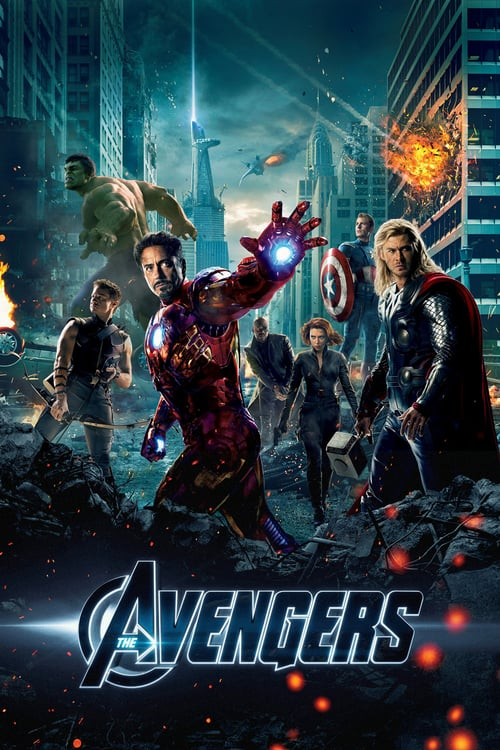

In [76]:
movie_ID = 89745
display_similar(movie_ID, num=5)

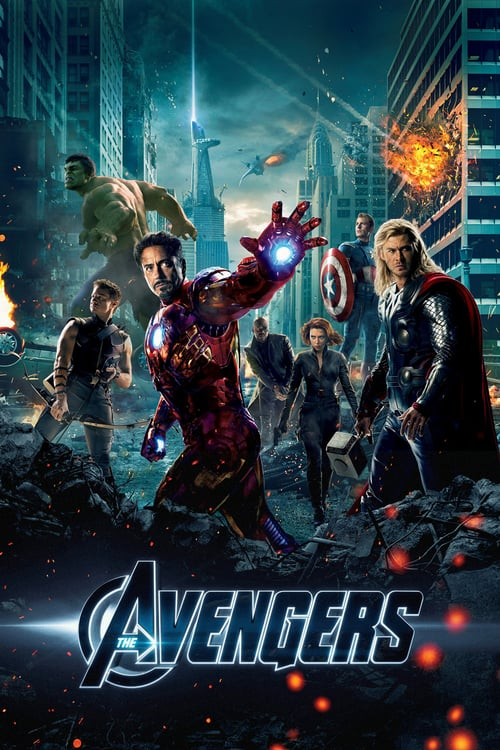

In [87]:
display_similar(89745, num=2, q="title:(NOT iron)")

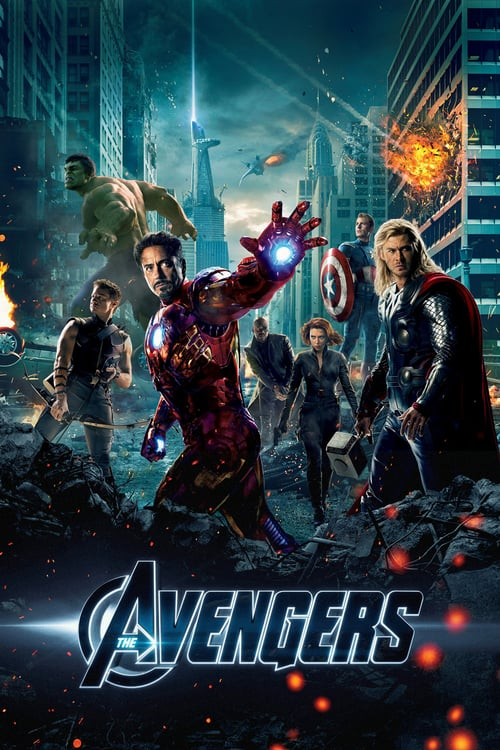

In [88]:
display_similar(89745, num=5, q="genres:children")

### 5.3 Find movies to recommend to a user(User - based)

In [98]:

display_user_recs(17, num=5, num_last=5)

In [105]:
display_user_recs(12, num=5, num_last=5)